In [2]:
# Basic functionalities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
import pickle

In [3]:
# Web crawling
import requests
from bs4 import BeautifulSoup
import pickle

In [4]:
# Text encoding
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Visualization
from wordcloud import WordCloud

In [6]:
# Text Processing
from nltk import word_tokenize, pos_tag
import nltk
# nltk.set_proxy('SYSTEM PROXY')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [7]:
# Sentiment analysis
from textblob import TextBlob as tb

In [66]:
# Topic Modeling
from gensim import matutils, models
from gensim.models import LsiModel
import scipy.sparse

In [68]:
# Keyword Extraction
from summa.summarizer import summarize
from summa import keywords

# Retrieve Data

## Data from google drive

In [31]:
df = pd.read_csv('./scrap_all_transcript/transcript_paragraph_needed.csv')
# remove the "who" and sort the table with "comedian"
df = df[["comedian","transcript"]]
df.columns = ["Comedian","Transcript"]
df

,Comedian,Transcript
0,ramy youssef,and i feel bad for him i dont know if anybody ...
1,ramy youssef,i think it doesnt matter if he was lying or no...
2,ramy youssef,im not gonna let them do this man they put up ...
3,ramy youssef,thats why i had to watch the whole r kelly doc...
4,ramy youssef,its the music it makes you forget music can do...
...,...,...
2705,whitney cummings,i dont know if in general as a society were ge...
2706,whitney cummings,im worried im worried for the next generation ...
2707,whitney cummings,you guys are getting desensitized and its like...
2708,whitney cummings,thank you guys so much for coming out to the s...


In [32]:
# get corpus
corpus = df[['Comedian','Transcript']].set_index('Comedian')
corpus

,Transcript
Comedian,
ramy youssef,and i feel bad for him i dont know if anybody ...
ramy youssef,i think it doesnt matter if he was lying or no...
ramy youssef,im not gonna let them do this man they put up ...
ramy youssef,thats why i had to watch the whole r kelly doc...
ramy youssef,its the music it makes you forget music can do...
...,...
whitney cummings,i dont know if in general as a society were ge...
whitney cummings,im worried im worried for the next generation ...
whitney cummings,you guys are getting desensitized and its like...


#### Clean the data

In [33]:
def apply_data_cleansing(text):
    # Lowercase every words
    text = text.lower()
    # Remove every words with [blah blah blah] format
    text = re.sub('\[.*?\]', '', text)
    # Remove every words with (blah blah blah) format
    text = re.sub('\(.*?\)', '', text)
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of all the numbers or words that contain numbers
    text = re.sub('\w*\d\w*', '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [34]:
clean_corpus = pd.DataFrame(corpus.Transcript.apply(lambda x: apply_data_cleansing(x)))
clean_corpus_index = clean_corpus.reset_index()
clean_corpus_index

,Comedian,Transcript
0,ramy youssef,and i feel bad for him i dont know if anybody ...
1,ramy youssef,i think it doesnt matter if he was lying or no...
2,ramy youssef,im not gonna let them do this man they put up ...
3,ramy youssef,thats why i had to watch the whole r kelly doc...
4,ramy youssef,its the music it makes you forget music can do...
...,...,...
2705,whitney cummings,i dont know if in general as a society were ge...
2706,whitney cummings,im worried im worried for the next generation ...
2707,whitney cummings,you guys are getting desensitized and its like...
2708,whitney cummings,thank you guys so much for coming out to the s...


In [37]:
# Pickles the result for later usage
clean_corpus_index.to_pickle('./pickles_index/clean_corpus_index.pkl')

#### Retrieve only NOUNS of all transcripts

In [38]:
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [39]:
corpus = pd.read_pickle('./pickles_index/clean_corpus_index.pkl')

In [40]:
# Apply the nouns function to the transcripts to filter only on nouns
corpus_nouns_index = pd.DataFrame(corpus.Transcript.apply(nouns))
corpus_nouns_index.to_pickle('./pickles_index/corpus_nouns_index.pkl')

#### Retrieve NOUNS and ADJECTIVES of all transcripts

In [42]:
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [45]:
corpus = pd.read_pickle('./pickles_index/clean_corpus_index.pkl')
# Apply the nouns function to the transcripts to filter only on nouns
corpus_na_index = pd.DataFrame(corpus.Transcript.apply(nouns_adj))
corpus_na_index.to_pickle('./pickles_index/corpus_na_index.pkl')

# Analyize the transcripts

#### Text Encoding

In [48]:
def dtm(corpus, stop_words='english', pickle_filename="", save_pickle=False):
    cv = CountVectorizer(stop_words=stop_words)
    data_cv = cv.fit_transform(corpus.Transcript)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = corpus.index
    if save_pickle:
        pickle.dump(cv, open(pickle_filename, "wb"))        
    return data_dtm.transpose()

def tf_idf(corpus, stop_words='english', pickle_filename="", save_pickle=False):
    vectorizer = TfidfVectorizer(stop_words='english')
    data_v = vectorizer.fit_transform(corpus.Transcript)
    data_tfidf = pd.DataFrame(data_v.toarray(), columns=vectorizer.get_feature_names())
    data_tfidf.index = corpus.index
    if save_pickle:
        pickle.dump(vectorizer, open(pickle_filename, "wb"))        
    return data_tfidf.transpose()

#### Top words

In [49]:
def get_top_words(matrix_dataframe, number_of_words = 30):
    top_dict = {}
    for c in matrix_dataframe.columns:
        top = matrix_dataframe[c].sort_values(ascending=False).head(number_of_words)
        top_dict[c]= list(zip(top.index, top.values))
    return top_dict

In [50]:
# Get all kinds of corpus
clean_corpus = pd.read_pickle('./pickles_index/clean_corpus_index.pkl')
corpus_n = pd.read_pickle('./pickles_index/corpus_nouns_index.pkl')
corpus_na = pd.read_pickle('./pickles_index/corpus_na_index.pkl')

all_corpuses = [clean_corpus, corpus_n, corpus_na]

In [51]:
df_dtms = []
df_tf_idfs = []
dtm_tops = []
tf_idf_tops = []
for corpus in all_corpuses:
    # Document-Term Matrix
    df_dtm = dtm(corpus)
    # Tf-Idf Matrix
    df_tfidf = tf_idf(corpus)    
    # Get top words
    dtm_top = get_top_words(df_dtm)
    tf_idf_top = get_top_words(df_tfidf)
    
    df_dtms.append(df_dtm)
    df_tf_idfs.append(df_tfidf)
    dtm_tops.append(dtm_top)
    tf_idf_tops.append(tf_idf_top)

In [52]:
# Have a glimps on the top words of each transcript

df = pd.DataFrame(index=df_dtms[0].columns)
for i, corpus in enumerate(all_corpuses):
    dtm_top = dtm_tops[i]
    tf_idf_top = tf_idf_tops[i]
    df[f'corpus{i}_DTM'] = [[w[0] for w in words] for words in dtm_top.values()]
    df[f'corpus{i}_TF_IDF'] = [[w[0] for w in words] for words in tf_idf_top.values()]
    
df

,corpus0_DTM,corpus0_TF_IDF,corpus1_DTM,corpus1_TF_IDF,corpus2_DTM,corpus2_TF_IDF
0,"[like, know, think, just, thats, gonna, hes, g...","[like, empire, think, wouldve, wish, icecaps, ...","[youre, hes, head, empire, thats, wouldve, thi...","[empire, wouldve, contracts, realities, stolen...","[youre, hes, thats, empire, wish, head, bad, w...","[empire, wouldve, wish, contracts, icecaps, re..."
1,"[theres, just, did, like, thing, think, smolle...","[fest, fyre, smollett, theres, weve, pronounce...","[theres, thing, smollett, seed, killer, cause,...","[smollett, theres, pronounced, fyre, suis, je,...","[theres, smollett, fyre, thing, fest, serial, ...","[fest, fyre, smollett, theres, pronounced, sui..."
2,"[like, good, just, theyll, ignition, man, gonn...","[ignition, like, watched, beat, crying, mugsho...","[beat, im, ignition, man, things, time, crime,...","[ignition, beat, kellys, random, documentary, ...","[good, im, ignition, beat, man, spun, women, r...","[ignition, beat, mugshot, spun, distrust, used..."
3,"[like, believe, youre, doubt, know, kelly, pra...","[prayer, doubt, kelly, quran, devastating, all...","[doubt, youre, gon, hes, community, thats, god...","[doubt, quran, prayer, akbar, islam, booth, mu...","[gon, hes, doubt, youre, thats, song, people, ...","[doubt, quran, allahu, akbar, prayer, islam, b..."
4,"[like, know, michael, dont, just, lebron, jack...","[michael, like, lebron, jackson, warriors, kno...","[michael, jackson, man, person, kid, dont, mus...","[michael, jackson, warriors, music, superteam,...","[michael, man, jackson, music, hard, like, rig...","[michael, jackson, warriors, famous, music, su..."
...,...,...,...,...,...,...
2705,"[im, like, god, sex, squirting, just, want, kn...","[squirting, squirt, sex, anal, god, im, pushin...","[sex, god, thing, thats, im, years, fun, time,...","[sex, god, nope, tarp, fun, years, date, thing...","[im, god, sex, thats, thing, years, new, youre...","[sex, god, anal, im, nope, new, tarp, female, ..."
2706,"[just, like, guys, base, gonna, day, dick, im,...","[base, squirting, guys, just, dick, generation...","[base, dick, day, guys, generation, way, sex, ...","[base, dick, generation, virginity, day, boobs...","[base, day, dick, sex, generation, guys, beaut...","[base, dick, generation, virginity, sex, day, ..."
2707,"[like, guys, thing, gagging, just, dicks, feel...","[gagging, gag, psychology, guys, dicks, like, ...","[thing, guys, dicks, psychology, deal, youre, ...","[psychology, dicks, tricks, guys, thing, deal,...","[thing, guys, dicks, whats, tricks, youre, psy...","[psychology, dicks, tricks, guys, thing, deal,..."
2708,"[thank, guys, coming, special, selfie, just, b...","[thank, selfie, guys, special, cuties, dedicat...","[thank, feed, background, selfie, selfies, ang...","[cuties, selfies, thank, feed, selfie, mode, i...","[selfie, thank, big, special, instagram, backg...","[selfie, special, cuties, selfies, feed, thank..."


Since there are too many words that are common among all the transcript, we need to add them to the stop-word list and redo the text encoding again.

#### Extract all common words among the transcript

In [53]:
commons = []
for c in df.columns:
    words = []
    for r in df[c]:
        top = [word for word in r]
        for t in top:
            words.append(t)    
    commons.append(Counter(words).most_common())

In [54]:
common_words_list = []
for common in commons:
    new = [word for word, count in common if count > 6]
    common_words_list.append(np.array(new))
common_words_list

[array(['like', 'know', 'im', ..., 'stereotype', 'boobs', 'neal'],
       dtype='<U14'),
 array(['like', 'im', 'know', ..., 'pete', 'crenshaw', 'malaysia'],
       dtype='<U15'),
 array(['im', 'youre', 'thats', ..., 'toilets', 'towel', 'sheet'],
       dtype='<U15'),
 array(['im', 'youre', 'people', ..., 'jo', 'jefferies', 'furniture'],
       dtype='<U15'),
 array(['im', 'youre', 'thats', ..., 'kong', 'melbourne', 'sheet'],
       dtype='<U16'),
 array(['im', 'youre', 'people', ..., 'melbourne', 'neal', 'malaysia'],
       dtype='<U16')]

In [55]:
pickle.dump(common_words_list, open('./pickles_index/common_words_list_index.pkl', 'wb'))

#### Add the stop words to the original stop word list and redo the text encoding

In [56]:
stop_words_list = []
for common_words in common_words_list:
    stop_words = text.ENGLISH_STOP_WORDS.union(common_words)
    stop_words_list.append(stop_words)

In [78]:
for i, stop_words in enumerate(stop_words_list):
    if i % 2 == 0:
        # Document-Term Matrix
        df_dtm = dtm(corpus, stop_words, f'./pickles_index/index_corpus{int(i/2)}_cv.pkl', save_pickle=True)
        # Transpose back to comedians as index for topic modeling
        df_dtm.to_pickle(f'./pickles_index/index_corpus{int(i/2)}_dtm.pkl')
    else:
        # Tf-Idf Matrix
        df_tfidf = tf_idf(corpus, stop_words, f'./pickles_index/index_corpus{int((i-1)/2)}_tf_idf.pkl', save_pickle=True)  
        # Transpose back to comedians as index for topic modeling  
        df_tfidf.to_pickle(f'./pickles_index/index_corpus{int((i-1)/2)}_tim.pkl')

### Visualize the top words with WordCloud

In [100]:
# 
wc_list = []
for stop_words in stop_words_list:
    wc = WordCloud(stopwords=stop_words,
                   background_color="white", 
                   colormap="Dark2",
                   max_font_size=150, 
                   random_state=42)
    wc_list.append(wc)

In [41]:
### the index should be 1 < num < 25
# plt.rcParams['figure.figsize'] = [30,10]

# index_now = clean_corpus.index

# for i, wc in enumerate(wc_list):
#     fig = plt.figure()
#     if i == 0 or i == 1:
#         corpus = clean_corpus
#     elif i == 2 or i == 3:
#         corpus = corpus_n
#     elif i == 4 or i == 5:
#         corpus = corpus_na
#     print(f"------------- Stop words {i} -------------")
#     # Create subplots for each transcript
#     for index, comedian in enumerate(index_now):
#         wc.generate(corpus.Transcript[index])
#         plt.subplot(4, 6, index+1)
#         plt.imshow(wc, interpolation="bilinear")
#         plt.axis("off")
#         plt.title(index_now[index])

#     plt.show()

# Sentiment Analysis

In [58]:
corpus_filename = './pickles_index/corpus_na_index.pkl'
clean_corpus = pd.read_pickle(corpus_filename)

In [59]:
pol = lambda x: tb(x).sentiment.polarity
sub = lambda x: tb(x).sentiment.subjectivity

data = pd.DataFrame()
data['polarity'] = clean_corpus['Transcript'].apply(pol)
data['subjectivity'] = clean_corpus['Transcript'].apply(sub)
data

,polarity,subjectivity
0,0.023333,0.550000
1,0.032500,0.740000
2,0.133333,0.336111
3,0.525000,0.700000
4,0.002663,0.518672
...,...,...
2705,0.071338,0.487976
2706,-0.024861,0.549750
2707,-0.195455,0.531818
2708,0.066667,0.500397


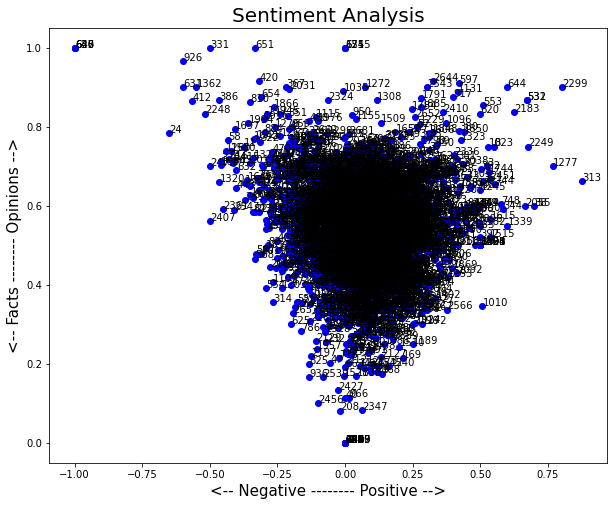

In [60]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data.index):
    x = data.polarity.loc[comedian]
    y = data.subjectivity.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data.index[index], fontsize=10)
#     plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

# Topic Modeling

# Latent Dirichlet Allocation (LDA)

In [69]:
def train_LDA_model(data_matrix, vectorizer, num_topics=4, passes=500):
    # df --> sparse matrix --> gensim corpus
    sparse_counts = scipy.sparse.csr_matrix(data_matrix)
    gensim_corpus = matutils.Sparse2Corpus(sparse_counts)
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    lda = models.LdaModel(corpus=gensim_corpus, id2word=id2word, num_topics=num_topics, passes=passes)
    
    corpus_transformed = lda[gensim_corpus]
    result = list(zip([max(ct, key=lambda x: x[1])[0] for ct in corpus_transformed], data_matrix.columns))
    return lda, result

In [71]:
# Load all matrices
clean_corpus_dtm = pd.read_pickle('./pickles_index/index_corpus0_dtm.pkl')
clean_corpus_tim = pd.read_pickle('./pickles_index/index_corpus0_tim.pkl')
corpus_noun_dtm = pd.read_pickle('./pickles_index/index_corpus1_dtm.pkl')
corpus_noun_tim = pd.read_pickle('./pickles_index/index_corpus1_tim.pkl')
corpus_na_dtm = pd.read_pickle('./pickles_index/index_corpus2_dtm.pkl')
corpus_na_tim = pd.read_pickle('./pickles_index/index_corpus2_tim.pkl')

In [79]:
# Load all vectorizers
clean_corpus_cv = pickle.load(open('./pickles_index/index_corpus0_cv.pkl', 'rb'))
clean_corpus_tf_idf = pickle.load(open('./pickles_index/index_corpus0_tf_idf.pkl','rb'))
corpus_noun_cv = pickle.load(open('./pickles_index/index_corpus1_cv.pkl','rb'))
corpus_noun_tf_idf = pickle.load(open('./pickles_index/index_corpus1_tf_idf.pkl','rb'))
corpus_na_cv = pickle.load(open('./pickles_index/index_corpus2_cv.pkl','rb'))
corpus_na_tf_idf = pickle.load(open('./pickles_index/index_corpus2_tf_idf.pkl', 'rb'))

In [80]:
clean_corpus_lda, result1 = train_LDA_model(clean_corpus_dtm, clean_corpus_cv)
clean_corpus_lda.print_topics()

[(0,
  '0.003*"mandela" + 0.002*"ci" + 0.002*"nelson" + 0.002*"io" + 0.002*"barack" + 0.002*"cowboy" + 0.002*"gli" + 0.002*"ogni" + 0.002*"poi" + 0.002*"fare"'),
 (1,
  '0.009*"gon" + 0.007*"ta" + 0.006*"russian" + 0.002*"ow" + 0.002*"immigrants" + 0.002*"na" + 0.002*"computer" + 0.002*"pill" + 0.002*"wan" + 0.002*"dennys"'),
 (2,
  '0.016*"gon" + 0.006*"ta" + 0.002*"terrorist" + 0.002*"mexican" + 0.002*"imma" + 0.002*"na" + 0.002*"dry" + 0.002*"attention" + 0.001*"sperm" + 0.001*"yogurt"'),
 (3,
  '0.023*"gon" + 0.011*"ta" + 0.006*"na" + 0.003*"tacos" + 0.002*"wan" + 0.002*"sun" + 0.002*"pocket" + 0.002*"medical" + 0.002*"wallet" + 0.001*"gas"')]

In [81]:
result1

[(2, 0),
 (3, 1),
 (3, 2),
 (2, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (3, 8),
 (1, 9),
 (3, 10),
 (2, 11),
 (3, 12),
 (1, 13),
 (3, 14),
 (1, 15),
 (0, 16),
 (3, 17),
 (3, 18),
 (1, 19),
 (2, 20),
 (0, 21),
 (0, 22),
 (2, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (3, 27),
 (2, 28),
 (2, 29),
 (3, 30),
 (2, 31),
 (2, 32),
 (3, 33),
 (0, 34),
 (1, 35),
 (2, 36),
 (0, 37),
 (2, 38),
 (1, 39),
 (3, 40),
 (3, 41),
 (2, 42),
 (3, 43),
 (1, 44),
 (3, 45),
 (2, 46),
 (1, 47),
 (3, 48),
 (3, 49),
 (3, 50),
 (2, 51),
 (3, 52),
 (1, 53),
 (3, 54),
 (1, 55),
 (3, 56),
 (1, 57),
 (3, 58),
 (3, 59),
 (3, 60),
 (3, 61),
 (3, 62),
 (3, 63),
 (1, 64),
 (3, 65),
 (2, 66),
 (0, 67),
 (3, 68),
 (2, 69),
 (3, 70),
 (3, 71),
 (3, 72),
 (0, 73),
 (3, 74),
 (3, 75),
 (3, 76),
 (0, 77),
 (2, 78),
 (1, 79),
 (0, 80),
 (1, 81),
 (2, 82),
 (1, 83),
 (3, 84),
 (2, 85),
 (1, 86),
 (0, 87),
 (0, 88),
 (3, 89),
 (0, 90),
 (3, 91),
 (0, 92),
 (3, 93),
 (3, 94),
 (3, 95),
 (3, 96),
 (2, 97),
 (3, 98),
 (3, 99),
 (3, 100),

In [82]:
clean_corpus_lda, result2 = train_LDA_model(clean_corpus_tim, clean_corpus_tf_idf)
clean_corpus_lda.print_topics()

[(0,
  '0.000*"hitler" + 0.000*"cherries" + 0.000*"guten" + 0.000*"tag" + 0.000*"shabinarussell" + 0.000*"shabina" + 0.000*"germany" + 0.000*"files" + 0.000*"forensic" + 0.000*"kuala"'),
 (1,
  '0.001*"di" + 0.001*"che" + 0.001*"non" + 0.001*"il" + 0.000*"una" + 0.000*"sono" + 0.000*"indigenous" + 0.000*"la" + 0.000*"le" + 0.000*"cazzo"'),
 (2,
  '0.001*"que" + 0.001*"el" + 0.001*"es" + 0.001*"lo" + 0.000*"pero" + 0.000*"los" + 0.000*"por" + 0.000*"una" + 0.000*"la" + 0.000*"qué"'),
 (3,
  '0.006*"im" + 0.005*"youre" + 0.004*"people" + 0.004*"thats" + 0.003*"right" + 0.003*"man" + 0.003*"shit" + 0.003*"time" + 0.003*"dont" + 0.003*"guy"')]

In [83]:
result2

[(3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (3, 27),
 (3, 28),
 (3, 29),
 (3, 30),
 (3, 31),
 (3, 32),
 (3, 33),
 (3, 34),
 (3, 35),
 (3, 36),
 (3, 37),
 (3, 38),
 (3, 39),
 (3, 40),
 (3, 41),
 (3, 42),
 (3, 43),
 (3, 44),
 (3, 45),
 (3, 46),
 (3, 47),
 (3, 48),
 (3, 49),
 (3, 50),
 (3, 51),
 (3, 52),
 (3, 53),
 (3, 54),
 (3, 55),
 (3, 56),
 (3, 57),
 (3, 58),
 (3, 59),
 (3, 60),
 (3, 61),
 (3, 62),
 (3, 63),
 (3, 64),
 (3, 65),
 (3, 66),
 (3, 67),
 (3, 68),
 (3, 69),
 (3, 70),
 (3, 71),
 (3, 72),
 (3, 73),
 (3, 74),
 (3, 75),
 (3, 76),
 (3, 77),
 (3, 78),
 (3, 79),
 (3, 80),
 (3, 81),
 (3, 82),
 (3, 83),
 (3, 84),
 (3, 85),
 (3, 86),
 (3, 87),
 (3, 88),
 (3, 89),
 (3, 90),
 (3, 91),
 (3, 92),
 (3, 93),
 (3, 94),
 (3, 95),
 (3, 96),
 (3, 97),
 (3, 98),
 (3, 99),
 (3, 100),

In [84]:
corpus_noun_lda, result3 = train_LDA_model(corpus_noun_dtm, corpus_noun_cv)
corpus_noun_lda.print_topics()

[(0,
  '0.014*"little" + 0.007*"big" + 0.006*"bad" + 0.006*"real" + 0.004*"hot" + 0.004*"black" + 0.004*"new" + 0.003*"great" + 0.003*"beautiful" + 0.003*"different"'),
 (1,
  '0.033*"black" + 0.025*"white" + 0.008*"big" + 0.007*"little" + 0.006*"real" + 0.005*"bad" + 0.005*"american" + 0.005*"better" + 0.004*"best" + 0.004*"old"'),
 (2,
  '0.010*"una" + 0.003*"mandela" + 0.002*"ci" + 0.002*"nelson" + 0.002*"ow" + 0.002*"ogni" + 0.002*"persone" + 0.002*"fatto" + 0.002*"tutto" + 0.002*"tizio"'),
 (3,
  '0.018*"little" + 0.010*"new" + 0.010*"old" + 0.009*"great" + 0.009*"bad" + 0.008*"indian" + 0.007*"big" + 0.007*"real" + 0.006*"best" + 0.006*"white"')]

In [85]:
result3

[(3, 0),
 (1, 1),
 (3, 2),
 (1, 3),
 (0, 4),
 (3, 5),
 (3, 6),
 (1, 7),
 (0, 8),
 (3, 9),
 (3, 10),
 (0, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (1, 16),
 (0, 17),
 (3, 18),
 (1, 19),
 (3, 20),
 (3, 21),
 (1, 22),
 (0, 23),
 (3, 24),
 (0, 25),
 (0, 26),
 (3, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (3, 31),
 (0, 32),
 (0, 33),
 (1, 34),
 (3, 35),
 (3, 36),
 (3, 37),
 (1, 38),
 (3, 39),
 (1, 40),
 (3, 41),
 (1, 42),
 (1, 43),
 (1, 44),
 (3, 45),
 (0, 46),
 (0, 47),
 (3, 48),
 (0, 49),
 (1, 50),
 (3, 51),
 (1, 52),
 (0, 53),
 (3, 54),
 (0, 55),
 (1, 56),
 (1, 57),
 (3, 58),
 (3, 59),
 (3, 60),
 (0, 61),
 (0, 62),
 (1, 63),
 (1, 64),
 (0, 65),
 (3, 66),
 (1, 67),
 (3, 68),
 (1, 69),
 (3, 70),
 (0, 71),
 (3, 72),
 (3, 73),
 (3, 74),
 (0, 75),
 (3, 76),
 (0, 77),
 (3, 78),
 (3, 79),
 (3, 80),
 (3, 81),
 (3, 82),
 (2, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (3, 87),
 (0, 88),
 (0, 89),
 (3, 90),
 (3, 91),
 (3, 92),
 (3, 93),
 (3, 94),
 (3, 95),
 (1, 96),
 (3, 97),
 (0, 98),
 (1, 99),
 (3, 100),

In [86]:
corpus_noun_lda, result4 = train_LDA_model(corpus_noun_tim, corpus_noun_tf_idf)
corpus_noun_lda.print_topics()

[(0,
  '0.000*"hava" + 0.000*"preug" + 0.000*"gouldet" + 0.000*"nagila" + 0.000*"forensic" + 0.000*"files" + 0.000*"gong" + 0.000*"citythey" + 0.000*"fatass" + 0.000*"admiration"'),
 (1,
  '0.001*"que" + 0.001*"di" + 0.001*"che" + 0.001*"una" + 0.001*"non" + 0.001*"el" + 0.001*"lo" + 0.001*"la" + 0.001*"es" + 0.001*"se"'),
 (2,
  '0.006*"im" + 0.005*"youre" + 0.004*"people" + 0.004*"thats" + 0.003*"right" + 0.003*"man" + 0.003*"shit" + 0.003*"time" + 0.003*"dont" + 0.003*"guy"'),
 (3,
  '0.000*"mancave" + 0.000*"hatred" + 0.000*"shabina" + 0.000*"shabinarussell" + 0.000*"sameday" + 0.000*"lag" + 0.000*"marcus" + 0.000*"jermaine" + 0.000*"divacup" + 0.000*"unamerican"')]

In [87]:
result4

[(2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 32),
 (2, 33),
 (2, 34),
 (2, 35),
 (2, 36),
 (2, 37),
 (2, 38),
 (2, 39),
 (2, 40),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 47),
 (2, 48),
 (2, 49),
 (2, 50),
 (2, 51),
 (2, 52),
 (2, 53),
 (2, 54),
 (2, 55),
 (2, 56),
 (2, 57),
 (2, 58),
 (2, 59),
 (2, 60),
 (2, 61),
 (2, 62),
 (2, 63),
 (2, 64),
 (2, 65),
 (2, 66),
 (2, 67),
 (2, 68),
 (2, 69),
 (2, 70),
 (2, 71),
 (2, 72),
 (2, 73),
 (2, 74),
 (2, 75),
 (2, 76),
 (2, 77),
 (2, 78),
 (2, 79),
 (2, 80),
 (2, 81),
 (2, 82),
 (2, 83),
 (2, 84),
 (2, 85),
 (2, 86),
 (2, 87),
 (2, 88),
 (2, 89),
 (2, 90),
 (2, 91),
 (2, 92),
 (2, 93),
 (2, 94),
 (2, 95),
 (2, 96),
 (2, 97),
 (2, 98),
 (2, 99),
 (2, 100),

In [88]:
corpus_na_lda, result5 = train_LDA_model(corpus_na_dtm, corpus_na_cv)
corpus_na_lda.print_topics()

[(0,
  '0.003*"ow" + 0.002*"immigrants" + 0.002*"doubt" + 0.002*"immigrant" + 0.002*"randy" + 0.002*"bombay" + 0.002*"canada" + 0.001*"pee" + 0.001*"vince" + 0.001*"toys"'),
 (1,
  '0.002*"russians" + 0.002*"namaste" + 0.001*"sperm" + 0.001*"vlad" + 0.001*"shoe" + 0.001*"chips" + 0.001*"wee" + 0.001*"starbucks" + 0.001*"olympics" + 0.001*"shooter"'),
 (2,
  '0.003*"mandela" + 0.003*"wallet" + 0.002*"nelson" + 0.002*"dan" + 0.002*"google" + 0.002*"harry" + 0.002*"parasites" + 0.002*"trap" + 0.001*"hoodie" + 0.001*"massage"'),
 (3,
  '0.002*"su" + 0.002*"dennys" + 0.002*"ci" + 0.002*"rumors" + 0.002*"cowboy" + 0.002*"ebola" + 0.002*"io" + 0.001*"yogurt" + 0.001*"ogni" + 0.001*"poi"')]

In [89]:
result5

[(3, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (0, 4),
 (2, 5),
 (0, 6),
 (2, 7),
 (1, 8),
 (0, 9),
 (1, 10),
 (1, 11),
 (0, 12),
 (2, 13),
 (2, 14),
 (0, 15),
 (1, 16),
 (0, 17),
 (2, 18),
 (2, 19),
 (1, 20),
 (0, 21),
 (2, 22),
 (0, 23),
 (0, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (2, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (1, 36),
 (1, 37),
 (1, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (1, 43),
 (0, 44),
 (0, 45),
 (2, 46),
 (3, 47),
 (0, 48),
 (1, 49),
 (0, 50),
 (2, 51),
 (2, 52),
 (3, 53),
 (1, 54),
 (1, 55),
 (1, 56),
 (2, 57),
 (0, 58),
 (2, 59),
 (1, 60),
 (0, 61),
 (1, 62),
 (0, 63),
 (2, 64),
 (2, 65),
 (1, 66),
 (2, 67),
 (0, 68),
 (2, 69),
 (2, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (2, 76),
 (2, 77),
 (3, 78),
 (2, 79),
 (3, 80),
 (1, 81),
 (2, 82),
 (3, 83),
 (3, 84),
 (2, 85),
 (2, 86),
 (0, 87),
 (1, 88),
 (1, 89),
 (0, 90),
 (3, 91),
 (2, 92),
 (0, 93),
 (0, 94),
 (3, 95),
 (3, 96),
 (0, 97),
 (1, 98),
 (2, 99),
 (1, 100),

In [90]:
corpus_na_lda, result6 = train_LDA_model(corpus_na_tim, corpus_na_tf_idf)
corpus_na_lda.print_topics()

[(0,
  '0.006*"im" + 0.005*"youre" + 0.004*"people" + 0.004*"thats" + 0.003*"right" + 0.003*"man" + 0.003*"shit" + 0.003*"time" + 0.003*"dont" + 0.003*"guy"'),
 (1,
  '0.000*"arbys" + 0.000*"meats" + 0.000*"markles" + 0.000*"rhames" + 0.000*"megan" + 0.000*"stones" + 0.000*"raisesay" + 0.000*"bridesmaidand" + 0.000*"favoritei" + 0.000*"nightyou"'),
 (2,
  '0.001*"que" + 0.001*"el" + 0.001*"es" + 0.001*"lo" + 0.000*"pero" + 0.000*"los" + 0.000*"por" + 0.000*"una" + 0.000*"la" + 0.000*"qué"'),
 (3,
  '0.001*"di" + 0.001*"che" + 0.001*"non" + 0.001*"il" + 0.000*"chinks" + 0.000*"una" + 0.000*"sono" + 0.000*"la" + 0.000*"mancave" + 0.000*"le"')]

In [91]:
result6

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),

In [92]:
groups = []
group_df = pd.DataFrame(index=[0,1,2,3])
for i, result in enumerate([result1, result2, result3, result4, result5, result6]):
    group = {}
    for r in result:
        if r[0] in group:
            group[r[0]].append(r[1])
        else:
            group[r[0]] = [r[1]]
    group_df[f'result_{i+1}'] = group.values()
    groups.append(group)

In [93]:
group_df.to_csv('./pickles_index/group.csv')

# Latent Semantic Analysis (LSA)

In [94]:
def train_LSA_model(data_matrix, vectorizer, num_topics=5):
    # df --> sparse matrix --> gensim corpus
    sparse_counts = scipy.sparse.csr_matrix(data_matrix)
    gensim_corpus = matutils.Sparse2Corpus(sparse_counts)
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    lsi = LsiModel(gensim_corpus, num_topics=num_topics, id2word=id2word)
    
    corpus_transformed = lsi[gensim_corpus]
    result = list(zip([max(ct, key=lambda x: x[1])[0] for ct in corpus_transformed], data_matrix.columns))
    return lsi, result

In [95]:
corpus_na_lsa, res = train_LSA_model(corpus_na_tim, corpus_na_tf_idf)
corpus_na_lsa.print_topics()

[(0,
  '0.291*"im" + 0.220*"youre" + 0.197*"people" + 0.170*"thats" + 0.165*"man" + 0.157*"right" + 0.153*"shit" + 0.142*"time" + 0.141*"dont" + 0.128*"hes"'),
 (1,
  '-0.488*"black" + -0.375*"white" + -0.371*"people" + 0.306*"women" + 0.208*"men" + 0.144*"youre" + 0.130*"girl" + 0.128*"woman" + -0.115*"man" + 0.112*"shes"'),
 (2,
  '-0.438*"women" + -0.332*"men" + -0.245*"black" + 0.230*"dad" + 0.226*"mom" + -0.211*"white" + 0.202*"im" + 0.192*"que" + -0.144*"woman" + -0.135*"man"'),
 (3,
  '0.487*"que" + 0.225*"el" + 0.204*"es" + 0.201*"una" + 0.197*"women" + 0.196*"lo" + 0.188*"la" + 0.173*"di" + 0.161*"che" + 0.148*"men"'),
 (4,
  '-0.346*"mom" + -0.283*"dad" + -0.269*"man" + -0.259*"kids" + -0.239*"women" + 0.219*"people" + 0.198*"youre" + -0.191*"shit" + -0.159*"son" + 0.159*"im"')]

In [96]:
res

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),

# Coherence Value

In [97]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [98]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Keyword Extraction

In [99]:
# Read the corpus
clean_corpus = pd.read_pickle('./pickles_index/clean_corpus_index.pkl')
corpus_nouns = pd.read_pickle('./pickles_index/corpus_nouns_index.pkl')
corpus_na = pd.read_pickle('./pickles_index/corpus_na_index.pkl')

In [100]:
print(keywords.keywords(clean_corpus.Transcript[4]))

like
michael got away
right
know
jackson
dont
white
happen
happening


In [101]:
print(keywords.keywords(corpus_nouns.Transcript[0]))

dont anybody dude
press
wouldve plan
youre


In [102]:
for i in range(5):
    print("")
    print(keywords.keywords(corpus_na.Transcript[i]))


bad
dont anybody
dude
empire
life hes black

theres
smollett
lie
lies
fest
serial
im

man
spun
random crime

youre
cause
hes

man
kid
kids
im
michael mad
jackson
like
famous person
